# Analyze balance (win rates) in Age of Empires II: Definitive Edition

In [559]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

data_dir = 'data/'
aoe2net_dir = f"{data_dir}aoe2net/"
out_dir = "./outputs/aoe2de/"

# Tested that this notebook works for *_big.csv files as well, but we will use the small files due to speed
matches = pd.read_csv(f'{aoe2net_dir}matches.csv')
players = pd.read_csv(f'{aoe2net_dir}match_players.csv')


# Explore datasets

In [560]:
# look at matches
display(matches.info())
matches.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331699 entries, 0 to 1331698
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   token           1331699 non-null  object 
 1   winning_team    1331699 non-null  int64  
 2   mirror          1331699 non-null  bool   
 3   ladder          1331699 non-null  object 
 4   patch           1331699 non-null  int64  
 5   average_rating  1287122 non-null  float64
 6   map             1331699 non-null  object 
 7   map_size        1331699 non-null  object 
 8   num_players     1331699 non-null  int64  
 9   server          1331699 non-null  object 
 10  duration        1331699 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 102.9+ MB


None

,token,winning_team,mirror,ladder,patch,average_rating,map,map_size,num_players,server,duration
0,HEVMmsI8GDCKKR2W,2,False,RM_1v1,35584,1180.0,hideout,tiny,2,ukwest,0:06:30
1,8a93d8306c758c0e,2,False,RM_1v1,36906,1671.0,nomad,tiny,2,westus2,0:03:39
2,1M1GiBrNTyfDdYpp,1,False,RM_TEAM,35584,1144.0,golden_pit,medium,4,brazilsouth,0:51:20
3,WqaPjpZ5YJsoF48B,1,False,RM_1v1,35584,943.0,golden_pit,tiny,2,eastus,0:37:14
4,sOZrU57m89qr0159,1,False,RM_1v1,35584,1046.0,mediterranean,tiny,2,ukwest,0:36:49


# Initial Questions - matches dataset
## What can we ask about matches?
- most popular maps
-- likely arabia (open) and arena (closed)
- most popular game type (ladder)
- what civs win most?
-- civ win rate vs other civs
-- civ win rate in map (arabia vs arena)
- what type of civ is better (infantry, cavalry, archer)
-- need to label civs by type manually
- in mirror matches, does the higher rated player win more often ? (probably). but we don't seem to have player rating here, just average rating
- where do people play most? (not really true as match server might not be where players are located)

## How do we subdivide (filter) data?
- by game version (patch)
- by game type (ladder)
- by player avg rating buckets
- by 1v1 games vs team games vs others (free for all)
- by region (server)
- by map type (closed maps vs open maps) - will have to manually label the maps as open/closed
- by patch

## What data might need to be cleaned?
- short duration games (someone quit) and long duration games (someone was afk)
- check null values

In [561]:
# look at matches
display(players.info())
players.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4075552 entries, 0 to 4075551
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   token   object 
 1   match   object 
 2   rating  float64
 3   color   object 
 4   civ     object 
 5   team    int64  
 6   winner  bool   
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 190.5+ MB


None

,token,match,rating,color,civ,team,winner
0,V2X8UjSoLUliuaqg,e2ef0bbea3378df2,1295.0,Purple,Goths,1,False
1,pafasA6Xv704IbMw,4a7b1a48021eb7b5,1549.0,Blue,Berbers,2,False
2,anI0CXCPML0E8UNB,c0582c309489f1de,NaN,Cyan,Lithuanians,2,False
3,BZW0KSg7oZ4Nmoa6,d1f34eed030ca372,1183.0,Red,Mayans,1,False
4,QAX39y010pa9q2Q6,346f298b1ced01fb,1326.0,Blue,Koreans,2,True


# Initial Questions - players dataset
## What can we ask about players?
- not name, because data is anonymized
- by token, we can see who won most, but that's useless perhaps
- we could see average number of games by binned ratings
- what color/civ picked most often (red/blue are defaults)

## How do we join with matches dataset?
- We can use the match id and do a join on that dataframe

## What do we look at once we have players and the matches they played?
- Now we can actually look at which civs are best (highest win rate)




# Color preferences

In [562]:
# What are player color preferences?
colors_df = players[~players['color'].isnull()]
# display(colors_df)
# display(len(colors_df))
color_counts = colors_df.groupby('color')['token'].count().reset_index()
color_percent = pd.DataFrame()
color_percent['color'] = color_counts['color']
color_percent['percent'] = color_counts['token']/len(colors_df)
color_percent.sort_values(by='percent', ascending=False, inplace=True)



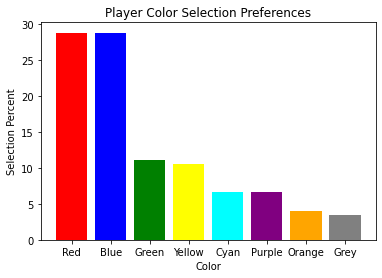

In [563]:
plt.bar(x=color_percent.color, height=color_percent.percent*100, color=color_percent.color)
plt.xlabel('Color')
plt.ylabel('Selection Percent')
plt.title('Player Color Selection Preferences')
plt.show()

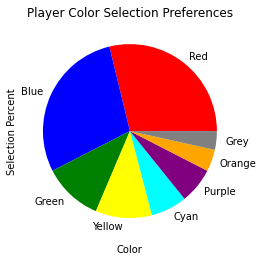

In [564]:
plt.pie(x=color_percent.percent, labels=color_percent.color, colors=color_percent.color)
plt.title('Player Color Selection Preferences')
plt.xlabel('Color')
plt.ylabel('Selection Percent')
plt.show()

# Data Cleaning

In [565]:
# Okay colors are pretty, but we need to look at win rates to determine if this game is balanced as per our hypothesis
# matches.info()
# we see nulls for average_rating column. perhaps this is for players new to the game who have no rating (i.e., this is their first game).
# matches_copy = matches_copy.dropna(subset=['average_rating']) # don't need this if we just drop that column
# we have 1331699 non null for everything else, 1287122 for average_rating
# this will be our cleaned up matches. also we won't have to start from beginning and read csv if we mess up something
# we can also throw away useless columns
# print(matches.columns)
matches_copy = matches[['token', 'winning_team', 'ladder', 'patch', 'num_players', 'duration']].copy()
players_copy = players[['token', 'match', 'rating', 'civ', 'team', 'winner']].copy()



In [566]:
# rename columns
matches_copy = matches_copy.rename(columns={'token': 'match_token'})
players_copy = players_copy.rename(columns={'token': 'player_token', 'match': 'match_token'})
players_copy = players_copy.dropna(subset=['rating'])

In [567]:
# join the datasets
mp_df = pd.merge(matches_copy, players_copy, on='match_token')

# Filter data

In [568]:
# mp_df = mp_df[mp_df.ladder == 'RM_1v1']
# we only want to look at the latest patch for now. maybe later we can look at balance across patches or how patches affect balance?
# most_recent_patch = max(matches.patch.unique()) # filter by this for now
# mp_df = mp_df[mp_df.patch == most_recent_patch]

def get_filtered_matches_players(df=mp_df, ladder='RM_1v1',
                                 patches=list([max(matches.patch.unique())]))->pd.DataFrame:
    """
    :param df: the dataframe to filter. default matches_players (mp_df)
    :param ladder: 'RM_1v1' or 'RM_TEAM'
    :param patches: list of what patches to filter by. default
    :return: a filtered matches_players dataframe
    """
    df = df[df.ladder == ladder]
    df = df[df.patch.isin(patches)]
    return df


# Analyze civilization win rates

In [569]:
# we only want to look at 1v1 games on the latest patch for now to determine balance
mp_df_latest_patch = get_filtered_matches_players()
# look at win rates for the latest patch
win_rates = mp_df_latest_patch.groupby('civ')[['winner']].mean().reset_index().rename(columns={'winner': 'win_rate'}).sort_values(by='win_rate', ascending=False)


In [570]:
from itertools import chain

# Get top X and bottom X civs
top_bottom_count = 10
locs = list(chain(range(top_bottom_count),range(-top_bottom_count,0))) # 0,1,2,3,4,-5,-4,-3,-2,-1
top_bottom_win_rates = win_rates.iloc[locs]


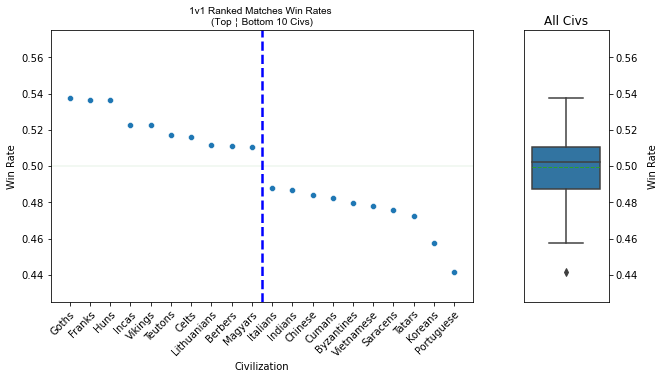

In [571]:
# plot win rates
# plt.figure(figsize=(25,10))
plt.subplots(1, 2, sharey=True, figsize=(10,5), gridspec_kw={'width_ratios': [5,1]})
ax = plt.subplot(1,2,1)
sns.scatterplot(x=top_bottom_win_rates.civ, y=top_bottom_win_rates.win_rate)
plt.ylim(.425,.575)
# rotation see: https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label-in-matplotlib
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.xlabel('Civilization')
plt.ylabel('Win Rate')

# draw a line at 50% to show how close to a coin flip this is
plt.axhline(0.5, color='green', linestyle='solid', linewidth='.1')
# Want to use broken pipe character ￤ so change font for the title
import matplotlib.font_manager as mfm
font_path = '/Library/Fonts/Arial Unicode.ttf'
prop = mfm.FontProperties(fname=font_path)
plt.title(f'1v1 Ranked Matches Win Rates \n(Top￤Bottom {top_bottom_count} Civs)', fontproperties=prop)
# draw separator
mid = (2*top_bottom_count-1)/2
plt.axvline(mid, color='blue', linestyle='--', linewidth='2.5')

# Oren said to use a boxplot for the above as it would be a better representation for mean
ax = plt.subplot(1,2,2)
plt.tick_params(left=False, bottom=False, labelleft=False, right=True, labelright=True, labelbottom=False)
plt.title('All Civs')
plt.ylabel('Win Rate', labelpad=10)
ax.yaxis.set_label_position('right')
sns.boxplot(data=win_rates, showmeans=True, meanline=True)

plt.savefig(f'{out_dir}top-bottom-scatterbox.png', bbox_inches='tight')

plt.show()

### Output win rate statistics

In [572]:
# win rate stats
win_rate_stats = win_rates.agg(['mean', 'median', 'std']).rename(columns={'win_rate':'Civ Win Rate'})
win_rate_stats.to_csv(f'{out_dir}stats.csv')

In [573]:
win_rates.head()

,civ,win_rate
11,Goths,0.537517
10,Franks,0.536673
12,Huns,0.536470
13,Incas,0.522556
34,Vikings,0.522458


## Analyze civilization win rates over patches (game updates)

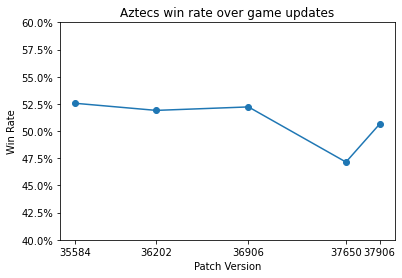

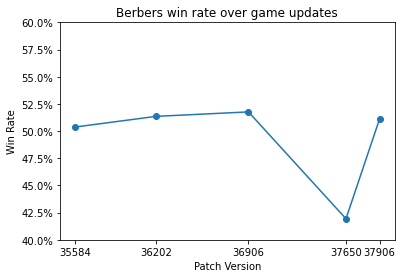

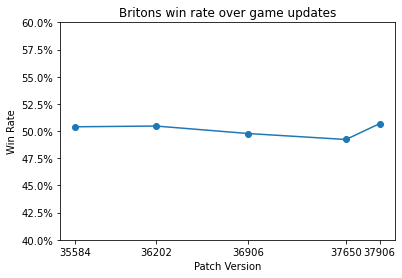

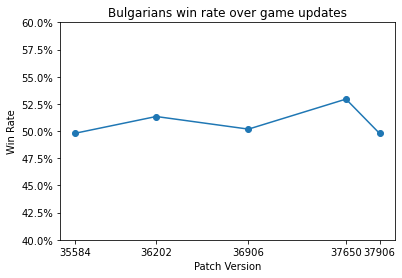

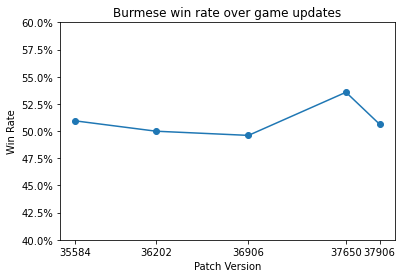

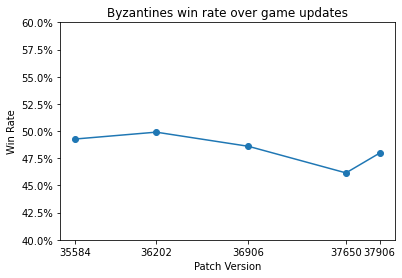

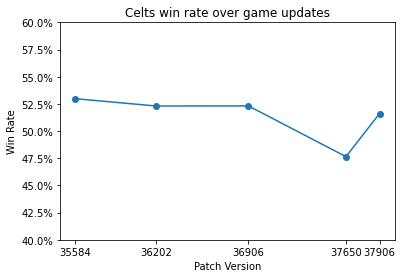

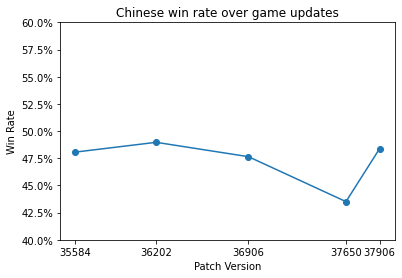

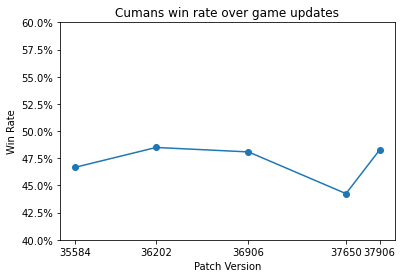

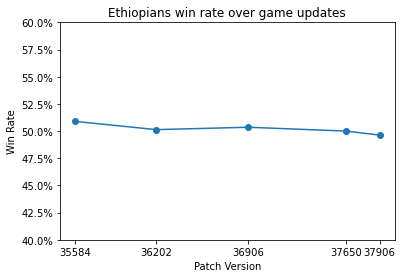

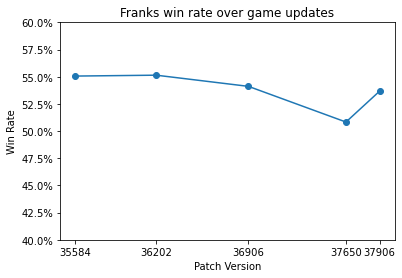

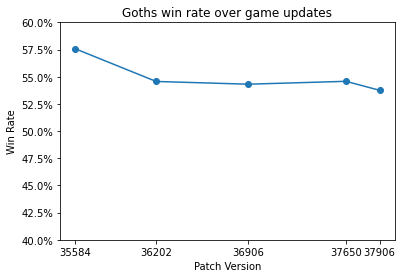

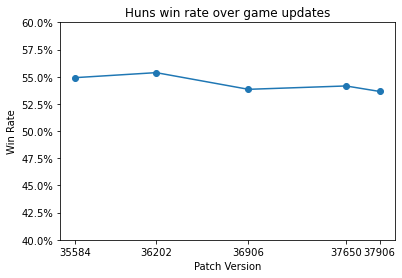

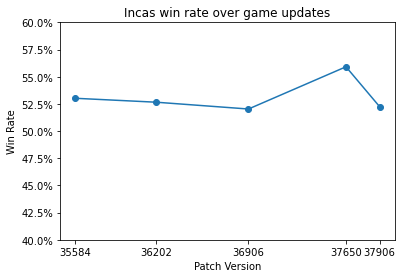

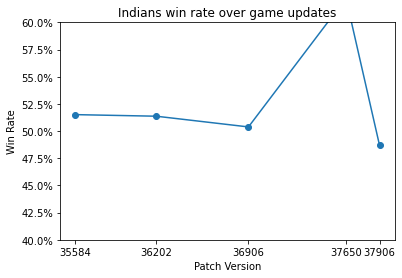

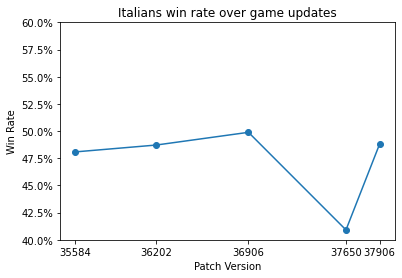

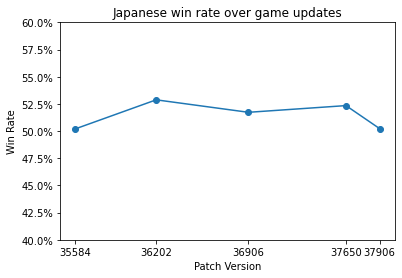

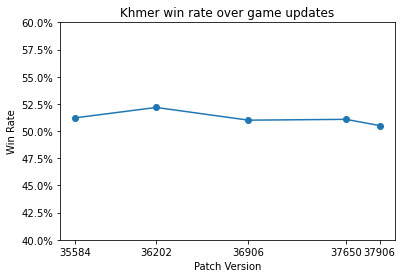

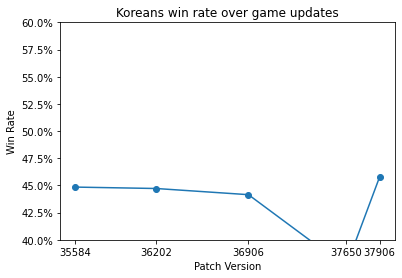

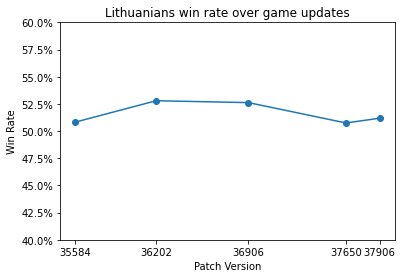

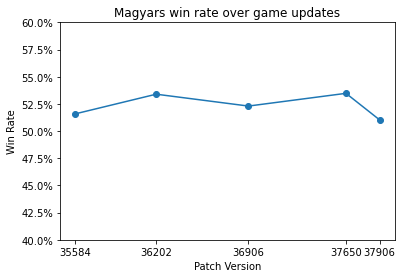

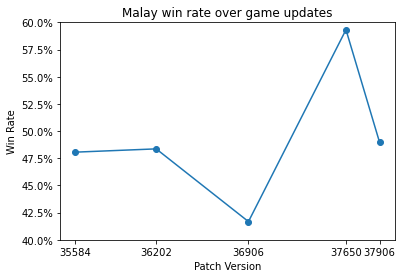

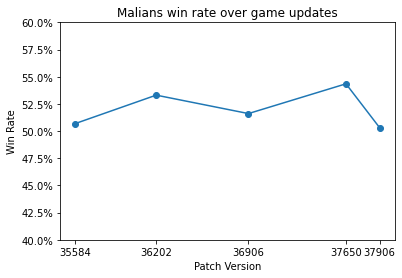

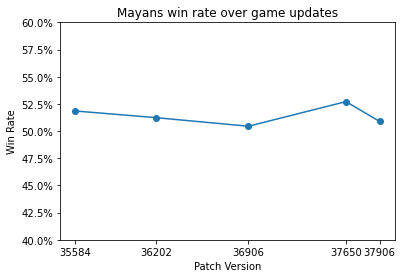

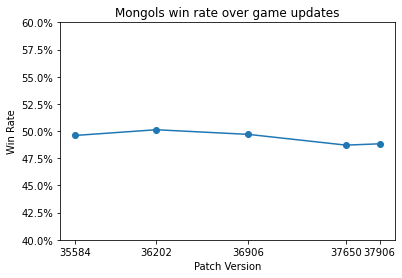

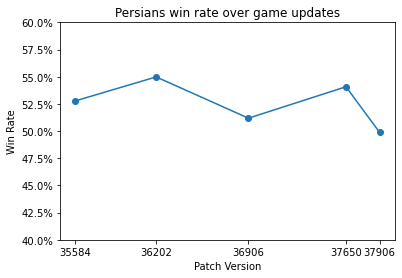

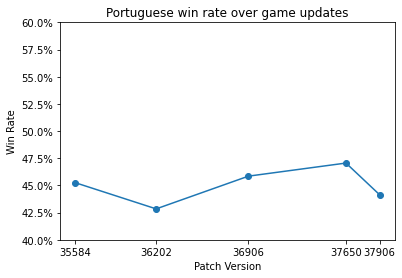

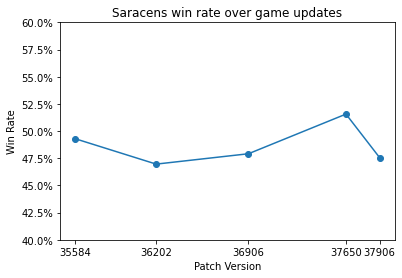

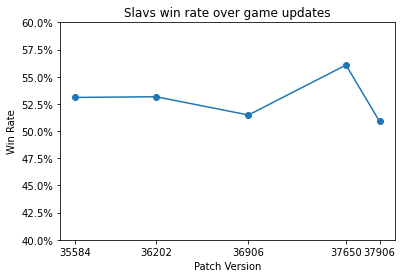

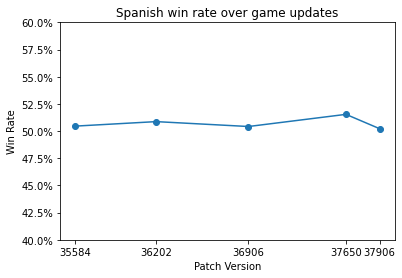

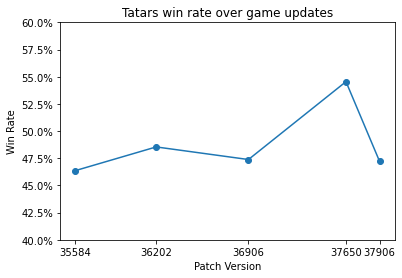

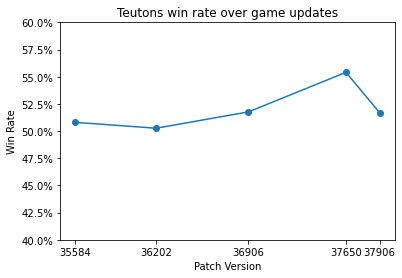

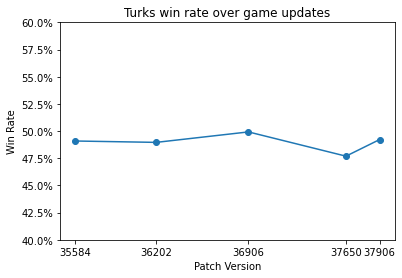

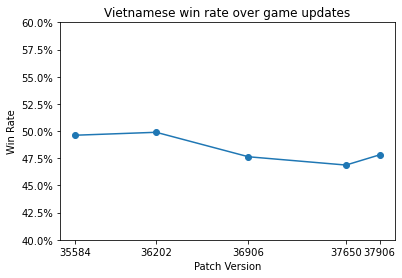

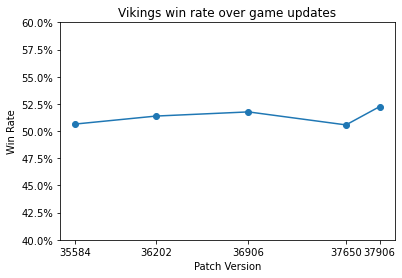

In [627]:
# we can use this to analyze balance across patches
mp_df_all_patches = get_filtered_matches_players(patches=list(matches.patch.unique())) # TODO should probably only use update patches
win_rates_all_patches = mp_df_all_patches.groupby(['patch', 'civ'])[['winner']].mean().reset_index().rename(columns={'winner': 'win_rate'}).sort_values(by='patch')

# toggle plotting all civilizations vs ones we are interested in
civs_to_plot = list(sorted(set(win_rates_all_patches.civ))) # all 35 civs
# civs_to_plot = ['Goths', 'Portuguese'] # top/bottom from earlier analysis

for civ in civs_to_plot:
    civ_rates = win_rates_all_patches[win_rates_all_patches['civ'] == civ]
    _, ax = plt.subplots()
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    plt.title(f'{civ} win rate over game updates')
    plt.ylim((.4,.6))
    plt.xlabel(f'Patch Version')
    plt.ylabel(f'Win Rate')
    plt.xticks(civ_rates.patch, civ_rates.patch)
    plt.scatter(data=civ_rates, x='patch', y='win_rate')
    plt.plot(civ_rates.patch, civ_rates.win_rate)
    plt.savefig(f'{out_dir}{civ}-win-rate-all-patches.png', bbox_inches='tight')
    plt.show()


### Compare graphs against balance notes in `hd_de_patches.csv` to see if balance changes affected win rates
E.g., Goths were nerfed in 36202

## Analyze civilization vs civilization win rates

In [574]:
mp_df_latest_patch.head()

,match_token,winning_team,ladder,patch,num_players,duration,player_token,rating,civ,team,winner
266,7a7ed006cbdff140,1,RM_1v1,37906,2,0:33:34,38b6093bd2b7f5e1,1108.0,Malians,1,True
267,7a7ed006cbdff140,1,RM_1v1,37906,2,0:33:34,1f50b7c3bdef14a2,1122.0,Britons,2,False
2555,06648359242f635a,2,RM_1v1,37906,2,0:24:45,f5e08049bb595a7a,1107.0,Incas,1,False
2556,06648359242f635a,2,RM_1v1,37906,2,0:24:45,df4bac171516f339,1074.0,Lithuanians,2,True
3080,efb85ce91164f4e8,1,RM_1v1,37906,2,0:39:35,bf3466d3a6685b09,1069.0,Persians,2,False


In [575]:
# Now let's see how one civ does against another (i.e., win rate civ vs civ)
# Look at the joined df in the format below:
"""
ID  match_token winning team ladder patch num_players duration player_token rating civ team winner
266,7a7ed006cbdff140,1,RM_1v1,37906,2,0:33:34,38b6093bd2b7f5e1,1108.0,Malians,1,True
267,7a7ed006cbdff140,1,RM_1v1,37906,2,0:33:34,1f50b7c3bdef14a2,1122.0,Britons,2,False
"""
# we see that each match has two players (as it's a 1v1) and one person won. above, Malians beat Britons

# join against ourselves on match token and see who won
# we should only select a few columns otherwise we get below as the columns when joining with ourself
"""
###########
civ_vs_civ = pd.merge(mp_df_latest_patch, mp_df_latest_patch, on='match_token', suffixes=['_self', '_enemy'])
Index(['match_token', 'winning_team_self', 'ladder_self', 'patch_self',
       'num_players_self', 'duration_self', 'player_token_self', 'rating_self',
       'civ_self', 'team_self', 'winner_self', 'winning_team_enemy',
       'ladder_enemy', 'patch_enemy', 'num_players_enemy', 'duration_enemy',
       'player_token_enemy', 'rating_enemy', 'civ_enemy', 'team_enemy',
       'winner_enemy'],
"""
civ_vs_civ = pd.merge(mp_df_latest_patch, mp_df_latest_patch[['match_token', 'player_token', 'civ']], on='match_token', suffixes=['', '_enemy'])
"""
now we get a better columns:
civ_vs_civ.columns = Index(['match_token', 'winning_team', 'ladder', 'patch', 'num_players',
                            'duration', 'player_token', 'rating', 'civ', 'team', 'winner',
                            'player_token_enemy', 'civ_enemy'],
                           dtype='object')
"""
# TODO check if we can merge on ourselves but not include if there is a collision on player_token. i.e., don't merge if a row is the same player
# Drop rows where player_token is not the same as player_token_enemy
civ_vs_civ = civ_vs_civ[civ_vs_civ.player_token != civ_vs_civ.player_token_enemy]
civ_vs_civ.head()

,match_token,winning_team,ladder,patch,num_players,duration,player_token,rating,civ,team,winner,player_token_enemy,civ_enemy
1,7a7ed006cbdff140,1,RM_1v1,37906,2,0:33:34,38b6093bd2b7f5e1,1108.0,Malians,1,True,1f50b7c3bdef14a2,Britons
2,7a7ed006cbdff140,1,RM_1v1,37906,2,0:33:34,1f50b7c3bdef14a2,1122.0,Britons,2,False,38b6093bd2b7f5e1,Malians
5,06648359242f635a,2,RM_1v1,37906,2,0:24:45,f5e08049bb595a7a,1107.0,Incas,1,False,df4bac171516f339,Lithuanians
6,06648359242f635a,2,RM_1v1,37906,2,0:24:45,df4bac171516f339,1074.0,Lithuanians,2,True,f5e08049bb595a7a,Incas
10,4c4a14ca5dad7b26,2,RM_1v1,37906,2,0:23:31,302d40907142d665,1096.0,Franks,1,False,f235f429d3c5debe,Khmer


In [576]:
"""
>> First, get these columns from civ_vs_civ. Then need to convert this df into a 2D array to pass to seaborn's heatmap
civ    |    civ_enemy   | win_rate
Aztecs |    Aztecs      | 0.5
Aztecs |    Berbers     | 0.513..
  .    |      .         |   .

>> into a 2D array:

[[ 0.5, 0.513, ... ] # aztecs
 [ ...             ] # berbers
 [ ...             ] # etc
 .
 [ ...             ]]

>>> into a heatmap of avg win rates for civ vs civ
sns.heatmap(2D array)
"""
civ_wins_df = civ_vs_civ[['civ', 'civ_enemy', 'winner']] # temp df
avg_civ_wins_df = civ_wins_df.groupby(['civ', 'civ_enemy']).agg('mean').reset_index().rename(columns = {'winner':'win_rate'})


In [577]:
# num civs should be 35 (39 in actual game but our dataset is stale)
num_civs = len(set(civ_vs_civ.civ))
# civs: 35 unique civs; 0 -> 'Aztecs', 1 -> 'Berbers', ... etc. This is the label of the 2D array
civs = np.array(sorted(set(civ_vs_civ.civ)))
avg_civ_win_rates_2D = np.array(avg_civ_wins_df.win_rate).reshape((num_civs,num_civs))


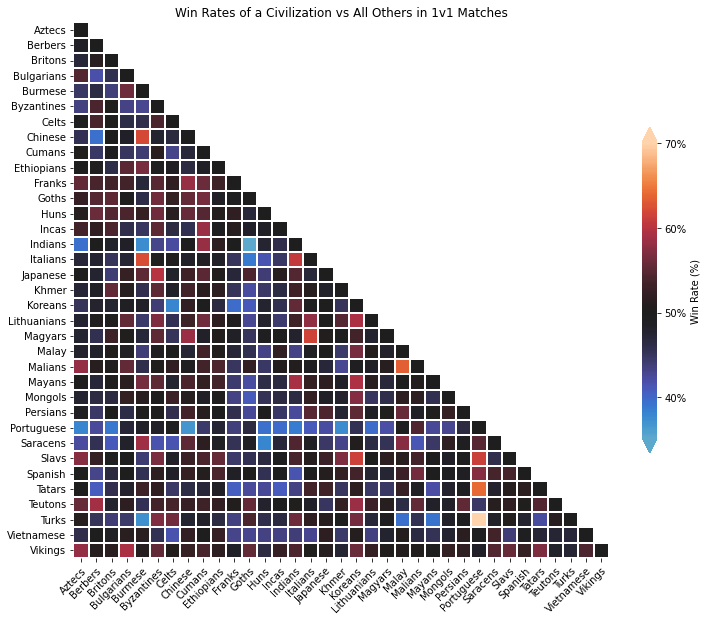

In [578]:

percents = 100*avg_civ_win_rates_2D # just so we can show percentage values in the colorbar...sigh
plt.figure(figsize=(12,12))
plt.title('Win Rates of a Civilization vs All Others in 1v1 Matches')
mask = np.triu(percents, 1) # mask the top half of the heatmap as it is repeated data
heatmap = sns.heatmap(percents,
                      linewidths=2, # cmap=sns.color_palette("vlag", as_cmap=True),
                      center=50, xticklabels=civs, yticklabels=civs,
                      square=True, mask=mask,
                      cbar_kws=dict(label='Win Rate (%)', shrink=.5, extend='both', ticks=[40,50,60,70], format=PercentFormatter(decimals=0)))
heatmap.set_xticklabels(civs, rotation=45, ha='right', rotation_mode='anchor')
plt.savefig(f'{out_dir}civ-vs-civ-all.png', bbox_inches='tight')
plt.show()